In [1]:
import time

print(f"Last update: {time.ctime(time.time())}")

Last update: Mon Apr 19 11:35:26 2021


# Documentation of particles 'stuck' on boundaries
In many parcels simulations particles end up moving onto parts of the grid where the velocity field is not defined because it is part of a solid. Particles drifting on a model surface ocean move onto land cells for example. In this tutorial we look at how this happens in different velocity fields. **Short conclusion: interpolated or assimilated velocity fields may result in particles getting 'stuck'.**

The tutorial first looks at how velocity fields are structured and what that means for where the solid-fluid boundaries are located. Then we look at how particles may end up getting 'stuck' in these velocity fields. How to handle these particles in parcels will be discussed in another notebook.

* [Velocity fields](#Velocity-fields)
    * Numerical models
    * Data assimilation products
    * Interpolations of velocity fields
* [A grid interpolated velocity fields - SMOC](#A-grids)
* [C grid numerical model - NEMO](#C-grids)

## Velocity fields
Parcels can handle several different types of velocity fields, which makes it widely applicable. This also means that the underlying code and therefore the accuracy of the calculated trajectories can differ, depending on the velocity data input. Even when Parcels runs smoothly with the velocity fields you use, it is good to realise how your velocity fields are structured and how those velocities are generated in the first place. 

Velocity data may be structured on a staggered (Arakawa-B or Arakawa-C) or unstaggered grid (Arakawa-A). The implementation of these grids is covered in [this tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb). Then, the grids may be rectilinear (lat-lon) or curvilinear and in spherical or flat coordinates.  

The source of your velocity data will influence how accurate and physically consistent parcels can calculate trajectories. Common sources are **numerical models**, **data assimilation products**, and **discretely sampled fields** from either of the previous two or from **observations**. The most important difference between these sources is that the numerical models are mathematically consistent and mass-conserving, while the others not so necessarily. This can cause trajectories to run into the solid-fluid boundaries of the velocity field. 

Solid-fluid boundaries are usually precisely defined in numerical models as boundary conditions are needed to solve the Navier-Stokes equations. The resulting model fluid flow then generally is not permitted to have a component normal to the solid-fluid boundaries. When such a field is interpolated information about the exact location of the boundary is lost. Similarly, in velocity fields derived from other sources the flow along the boundary is not strictly restricted.

Here we will look at two examples of velocity fields in parcels. We visualize the structure of the velocity field, briefly discuss the Parcels implementation and look at how particles get stuck.

In [2]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable, Field, ScipyParticle, AdvectionDiffusionM1

import numpy as np
import xarray as xr
from datetime import timedelta as delta
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from scipy import interpolate
import os
import math
from IPython.display import Image

def _check_file_exist(File: str): return os.path.isfile(File)

INFO: Compiled ParcelsRandom ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\libparcels_random_e6ba4b3a-d09a-465a-b36f-34e0e30db2e5.so


### A grids
Arakawa A grids are unstaggered grids where the velocities u, v (and w), pressure and other tracers are defined at the same position. In numerical models, these nodes can be located **at the corner or the center of the grid cells**. This means that the cell boundaries, and therefore the solid-fluid boundaries can either be located at the nodes or at 0.5 dx distance from the nodes respectively (see figure below).

Many ocean models are run on a C grid, because boundary conditions are more straightforward to implement there (see [C grid](#C-grids)). Often the C-grid output of these models is interpolated onto an A grid. This is the case for example in the SMOC data available from [CMEMS](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024). This consists of a rectilinear A grid velocity field. To visualize the land and ocean cells we can plot the velocity points and the cells between or around these points in figure 1.

In [3]:
# --------- Open dataset ---------
SMOCfile = 'SMOC_20190704_R20190705.nc'
SMOCfiles = ['SMOC_20190704_R20190705.nc','SMOC_20190705_R20190706.nc','SMOC_20190706_R20190707.nc','SMOC_20190707_R20190708.nc', 'SMOC_20190708_R20190709.nc']
flowdata_SMOC = xr.open_dataset(SMOCfile)


# --------- Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh ---------
dlon = flowdata_SMOC['longitude'][1]-flowdata_SMOC['longitude'][0] # 1/12 degree
dlat = flowdata_SMOC['latitude'][1]-flowdata_SMOC['latitude'][0]   # 1/12 degree

# Outside corner coordinates - coordinates + 0.5 dx
x_outcorners,y_outcorners = np.meshgrid(np.append((flowdata_SMOC['longitude']-0.5*dlon),(flowdata_SMOC['longitude'][-1]+0.5*dlon)),
                np.append((flowdata_SMOC['latitude']-0.5*dlat),(flowdata_SMOC['latitude'][-1]+0.5*dlat)))

# Inside corner coordinates - coordinates + 0.5 dx - needed to plot cells inbetween velocity field nodes 
x_incorners,y_incorners = np.meshgrid((flowdata_SMOC['longitude']+0.5*dlon)[:-1],
                (flowdata_SMOC['latitude']+0.5*dlat)[:-1])

# Center coordinates
x_centers, y_centers = np.meshgrid(flowdata_SMOC['longitude'],
                flowdata_SMOC['latitude'])


# --------- Velocity fields ---------
cells = np.zeros((len(flowdata_SMOC['latitude']),len(flowdata_SMOC['longitude']))) # Empty cells between coordinate nodes - essentially on inside corners

umask = np.ma.masked_invalid(flowdata_SMOC['uo'][0,0])                                 # Masking the flowfield where U = NaN

u_zeros = np.nan_to_num(flowdata_SMOC['uo'][0,0])                                      # Velocity field with NaN -> zero to be able to use in interp2d
f = interpolate.interp2d(flowdata_SMOC['longitude'],flowdata_SMOC['latitude'],u_zeros) # Interpolator

u_corners = f(x_incorners[0,:],y_incorners[:,0])                                                   # Velocity field interpolated on the inside corners

udmask = np.ma.masked_values(u_corners,0)                                                          # Masking the interpolated flowfield where U = 0


# --------- Plotting domain ---------
lonminx = 2100
lonmaxx = 2500
latminx = 1300
latmaxx = 1750

SMOC_U = flowdata_SMOC['uo'][0,0,latminx:latmaxx,lonminx:lonmaxx].fillna(-100)                     # Selected velocity domain to plot

### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap('Blues')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0
my_cmap = ListedColormap(my_cmap)

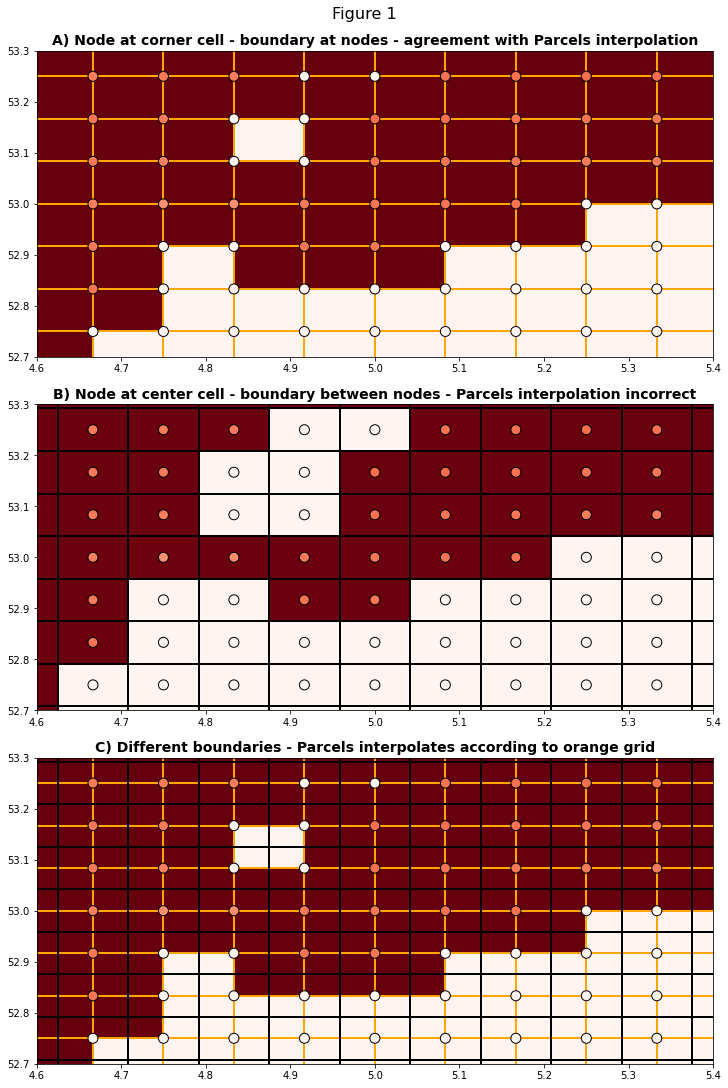

In [4]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15),constrained_layout=True)
fig.suptitle('Figure 1', fontsize=16)

ax1.set_xlim(4.6,5.4)
ax1.set_ylim(52.7,53.3)
ax1.set_title('A) Node at corner cell - boundary at nodes - agreement with Parcels interpolation', fontsize=14, fontweight = 'bold')
ax1.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='Reds',vmin=-2,vmax=2,edgecolors='k')

ax2.set_xlim(4.6,5.4)
ax2.set_ylim(52.7,53.3)
ax2.set_title('B) Node at center cell - boundary between nodes - Parcels interpolation incorrect', fontsize=14, fontweight = 'bold')
ax2.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],SMOC_U,cmap='Reds',edgecolors='k',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='Reds',vmin=-2,vmax=2,edgecolors='k')

ax3.set_xlim(4.6,5.4)
ax3.set_ylim(52.7,53.3)
ax3.set_title('C) Different boundaries - Parcels interpolates according to orange grid', fontsize=14, fontweight = 'bold')
ax3.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
# ax3.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],SMOC_U,cmap='Reds',edgecolors='k',linewidth=1)
ax3.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],cells[latminx:latmaxx,lonminx:lonmaxx],cmap=my_cmap,edgecolors='black')
ax3.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='Reds',vmin=-2,vmax=2,edgecolors='k')

#### Parcels bilinear interpolation
On Arakawa A grids, parcels uses a simple bilinear interpolation to find the particle velocity at a specific location in a cell. This does not take into account any boundary condition and makes the cross-boundary component of any of the four (2D) nearest points persist in the limit toward the boundary. In figure 1A you can see how boundaries are 'interpreted' by Parcels' bilinear interpolation. Given a small enough dt, particles trajectories will not cross any lines between two white (land) nodes. This means that particle trajectories will not move onto land. They can however get stuck on the boundary once they come really close, as we will see in the following.

#### How do particles get stuck?
Here we create a parcels simulation of trajectories of particles released near and on the 'land' cells in the velocity field and see how the bilinear interpolation causes particles to get stuck.

In [5]:
if _check_file_exist("SMOC.nc"):
    print('File exists - doing nothing')
else:
    print('Running simulation')
    SMOCfile = 'SMOC_201907*.nc'
    filenames = {'U': SMOCfile,
                 'V': SMOCfile}

    variables = {'U': 'uo',
                 'V': 'vo'}

    dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
                  'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

    npart = 3  # number of particles to be released
    lon = np.linspace(7, 7.2, npart, dtype=np.float32)
    lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
    lons, lats = np.meshgrid(lon,lat)
    time = np.zeros(lons.size)

    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

    kernels = pset.Kernel(AdvectionRK4)

    output_file = pset.ParticleFile(name="SMOC.nc", outputdt=delta(hours=1))

    pset.execute(kernels, runtime=delta(hours=119), dt=delta(minutes=12),
                 output_file=output_file)
    output_file.close()  # export the trajectory data to a netcdf file

File exists - doing nothing


Particles moving toward the boundary will keep slowing down as long as the cross-boundary component of one of the 4 nearest velocity vectors is directed toward the boundary. The distance travelled each timestep will decrease to unrealistic values in the absence of local forces directing the flow along the boundary. If we define a particle to be stuck when it moves less than approximately 1 meter every hour, we can see how particles get stuck on the model boundary.

In [7]:
ds_SMOC = xr.open_dataset('SMOC.nc')

In [8]:
# Calculating when a particle is stuck
pdx = np.diff(ds_SMOC['lon'],axis=1,prepend=0)
pdy = np.diff(ds_SMOC['lat'],axis=1,prepend=0)
distance = np.sqrt(np.square(pdx)+np.square(pdy)) # approximation of the distance travelled
stuck = distance<1e-5 # [degrees] 1e-5 degrees ~~ 1 m in dt = 1 hour.

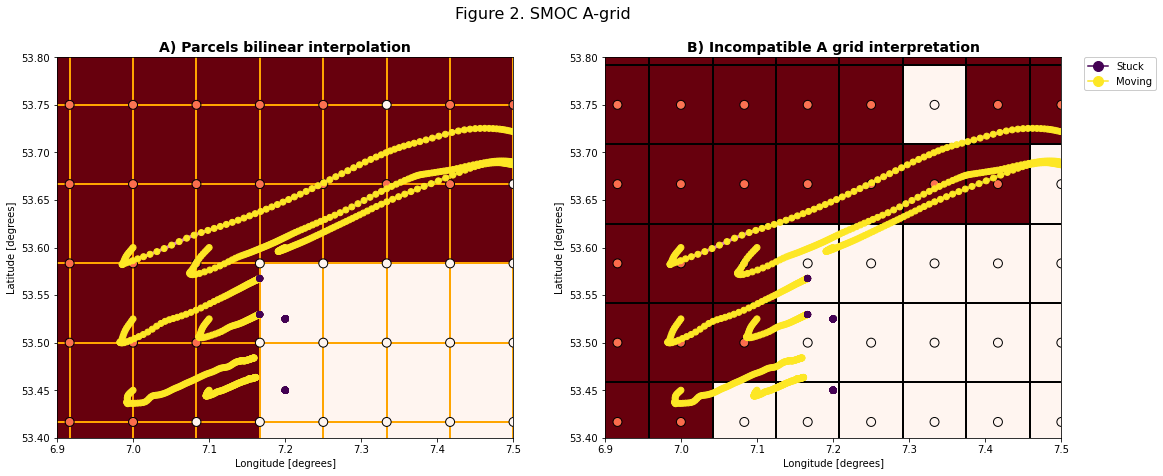

In [9]:
fig = plt.figure(figsize=(18,7))
fig.suptitle('Figure 2. SMOC A-grid', fontsize=16)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('A) Parcels bilinear interpolation', fontsize=14, fontweight = 'bold')
ax1.set_xlim(6.9, 7.5)
ax1.set_ylim(53.4, 53.8)

ax1.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=80,c=SMOC_U,cmap='Reds', vmin=-2, vmax=2, edgecolors='k', linewidth=1)
ax1.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC['lon'], ds_SMOC['lat'], c= stuck, cmap='viridis_r', zorder=2)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('B) Incompatible A grid interpretation', fontsize=14, fontweight = 'bold')
ax2.set_xlim(6.9, 7.5)
ax2.set_ylim(53.4, 53.8)

ax2.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=80,c=SMOC_U,cmap='Reds', vmin=-2, vmax=2, edgecolors='k', linewidth=1)
ax2.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax2.scatter(ds_SMOC['lon'], ds_SMOC['lat'], c=stuck, cmap='viridis_r', zorder=2)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10)]
ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

In figure 2A you can see how particles released in a 3x3 grid keep moving toward the boundary between two 'land' nodes. Since there is no boundary condition the U component of the two nearest 'ocean' nodes persists toward the boundary. 

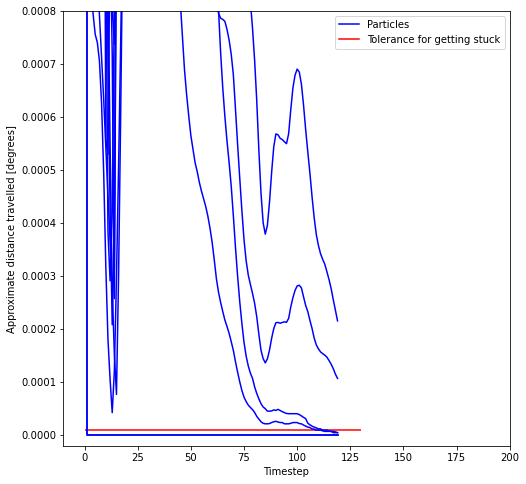

In [10]:
fig = plt.figure(figsize=(8,8))
ax=plt.axes()

ax.plot(distance.T, color='b')
ax.hlines(1e-5,0,130, color='r')
ax.set_ylabel('Approximate distance travelled [degrees]')
ax.set_xlabel('Timestep')
ax.set_ylim(-0.00002,0.0008)
ax.set_xlim(-10, 200)
custom_lines = [Line2D([0], [0], c = 'b'),
                Line2D([0], [0], c = 'r')]
ax.legend(custom_lines, ['Particles', 'Tolerance for getting stuck'], loc='upper right')
plt.show()

### C grids

On staggered grids, different types of boundary conditions can be satisfied simultaneously. On a C-grid, the velocities are defined on the cell-edges normal to the velocity-component and pressure, temperature and tracers are defined at the cell centers. This way, a [Dirichlet boundary condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) can be used for the velocities, while a [Neumann boundary condition](https://en.wikipedia.org/wiki/Neumann_boundary_condition) can be satisfied for the gradient of pressure. Here we are going to look at how Parcels interprets the the boundaries in a C grid. First we show how the velocites are staggered and how the velocity input necessary to create a fieldset results in the definition of boundaries in parcels. In this case a NEMO dataset is used, but the C grid fieldset is similar when loading other velocity fields like from MITgcm.

In [11]:
cufields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05U.nc')
cvfields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05V.nc')

xu_corners, yu_corners = np.meshgrid(np.arange(cufields['x'].values[0], cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-0.5, cufields['y'].values[-1]+0.5, 1))
xv_corners, yv_corners = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+0.5, 1),
                np.arange(cvfields['y'].values[0], cvfields['y'].values[-1]+1, 1))
cx_centers, cy_centers = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+1.5, 1),
                np.arange(cvfields['y'].values[0]-0.5, cvfields['y'].values[-1]+1.5, 1))
fx_corners, fy_corners = np.meshgrid(np.arange(cufields['x'].values[0]-1, cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-1, cufields['y'].values[-1]+1, 1))
c_cells = np.zeros((len(cufields['y']),len(cufields['x'])))



In [14]:
cu_zeros = np.nan_to_num(cufields['uos'][0])                                      # Velocity field with NaN -> zero to be able to use in interp2d
f = interpolate.interp2d(xu_corners[0,:],yu_corners[:,0],cu_zeros)                # Interpolator

cu_centers = f(cx_centers[0,:-1],cy_centers[:-1,0])                               # Velocity field interpolated on the T-points - center

cudmask = np.ma.masked_values(cu_centers,0)                                       # Masking the interpolated flowfield where U = 0

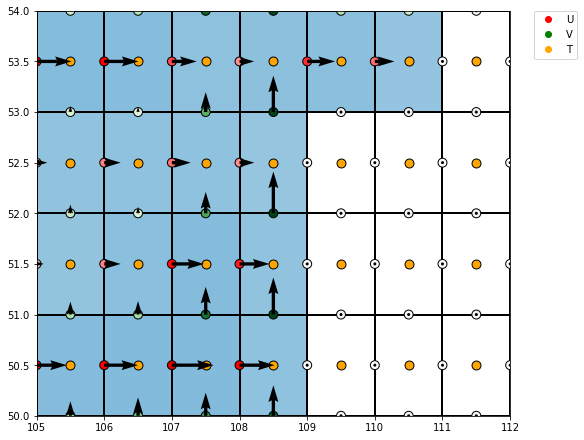

In [17]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)
ax1=plt.axes()

ax1.set_xlim(105, 112)
ax1.set_ylim(50, 54)
ax1.pcolormesh(fx_corners,fy_corners,cudmask,cmap='Blues',edgecolors='k',linewidth=1)
ax1.scatter(xu_corners,yu_corners, s=80,c=cufields['uos'][0],cmap='seismic',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'U')
ax1.scatter(xv_corners,yv_corners, s=80,c=cvfields['vos'][0],cmap='PRGn',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'V')
ax1.scatter(cx_centers,cy_centers, s=80,c='orange',edgecolor='k', label = 'T')
ax1.quiver(xu_corners,yu_corners,cufields['uos'][0],np.zeros(xu_corners.shape),angles='xy', scale_units='xy', scale=0.1, width=0.007)
ax1.quiver(xv_corners,yv_corners,np.zeros(xv_corners.shape),cvfields['vos'][0],angles='xy', scale_units='xy', scale=0.3, width=0.007)

custom_lines = [Line2D([0], [0], marker='o', color='r',lw=0),
                Line2D([0], [0], marker='o', color='g', lw=0),
                Line2D([0], [0], marker='o', color='orange', lw=0)]

ax1.legend(custom_lines, ['U', 'V', 'T'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Here you can see how a boundary can be traced along the cell edges where the velocity is zero. Because the velocities that are defined at the cell edges in a C-grid are the normal velocities, this ensures that the most important boundary condition in many models is satisfied: the normal-component of velocity is zero at the boundary. Parcels interpolates the velocities on a C-grid linearly in the direction of the component and constant throughout a cell in the direction normal to the component. This means that the cross-boundary component is linearly interpolated to zero at the boundary and the along-boundary component is constant towards the boundary.

#### Consistency with NEMO configuration
Here we look at how the lateral boundary conditions are implemented in NEMO. This is documented [here](https://www.nemo-ocean.eu/doc/node58.html). 

The normal-component of velocity, defined at the cell faces where the boundary is defined, is set to zero at all boundaries. See the figure below. This corresponds exactly with the velocity field in a Parcels fieldset detailed above.

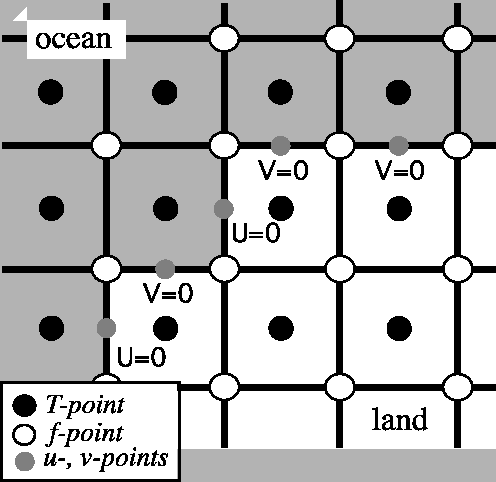

In [16]:
from IPython.display import Image
Image(filename='NEMO_latBC.png') 

There are different options for the tangential velocity in NEMO: a free-slip condition, a partial-slip condition and a no-slip condition. Since the tangential velocity is not defined at the boundary, this boundary condition is defined by a Neumann boundary condition: the normal derivative of the tangential velocity is specified. This derivative is schematically represented by a "ghost" velocity in the solid domain. The specified derivative is equivalent to what would result from the central difference between the tangential velocity at the nearest ocean cell and this "ghost" velocity. The type of boundary condition defines the direction and magnitude of this "ghost" velocity relative to the tangential velocity in the fluid domain. In Parcels, these "ghost" velocities may be used to determine how the velocity should be interpolated near the coast. **Question: Parcels interpolates piecewise-constant in the y-direction for the U velocity and in the x-direction for the V velocity right? If so, this probably results in a free-slip condition as shown in a) in the figure below** 

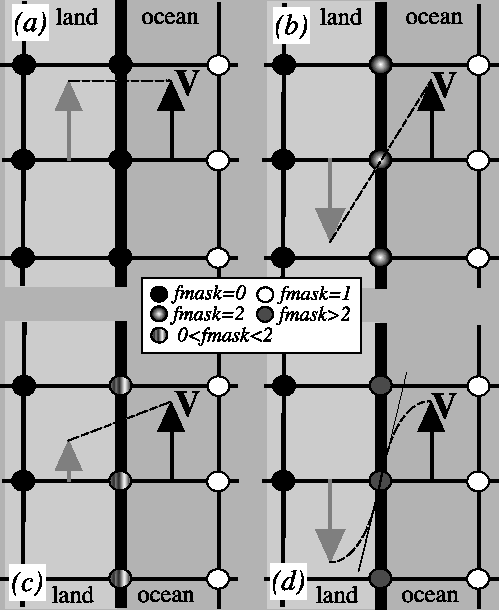

In [17]:
Image(filename='NEMO_ghost_vel.png')

If the interpolation in Parcels is piecewise-constant in the direction normal to the boundary, the tangential velocity at the boundary is the same as the tangential velocity in the last fluid cell: a free-slip boundary. If the interpolation is linear between the nodes at either side of the boundary, there would be a smaller tangential velocity at the boundary: a partial-slip boundary.

### Particle trajectories near the boundary in a C grid
Now let's see how particles move near the boundary in fieldset derived from the mass-conserving NEMO C grid. 

In [18]:
from glob import glob

data_path = 'NemoNorthSeaORCA025-N006_data/'
ufiles = sorted(glob(data_path+'ORCA*U.nc'))
vfiles = sorted(glob(data_path+'ORCA*V.nc'))
wfiles = sorted(glob(data_path+'ORCA*W.nc'))
mesh_mask = data_path + 'coordinates.nc'

coords = xr.open_dataset(mesh_mask, decode_times=False)

In [19]:
if _check_file_exist("Cgrid.nc"):
    print('File exists - doing nothing')
else:
    print('Running simulation')
    filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

    variables = {'U': 'uo',
                 'V': 'vo',
                 'W': 'wo'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

    fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

    npart = 10  # number of particles to be released
    lon = np.linspace(3 , 4, npart, dtype=np.float32)
    lat = 51.5 * np.ones(npart)
    time = np.zeros(npart)

    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

    output_file = pset.ParticleFile(name="Cgrid.nc", outputdt=delta(hours=1))
    pset.execute(AdvectionRK4, runtime=delta(days=10), dt=delta(minutes=5),
                 output_file=output_file)
    output_file.close()  # export the trajectory data to a netcdf file

File exists - doing nothing


In [20]:
data_NEMO = xr.open_dataset('Cgrid-stuck.nc')

In [21]:
pdx = np.diff(data_NEMO['lon'],axis=1,prepend=0)
pdy = np.diff(data_NEMO['lat'],axis=1,prepend=0)
distance = np.sqrt(np.square(pdx)+np.square(pdy))
stuck = distance<(1e-5)

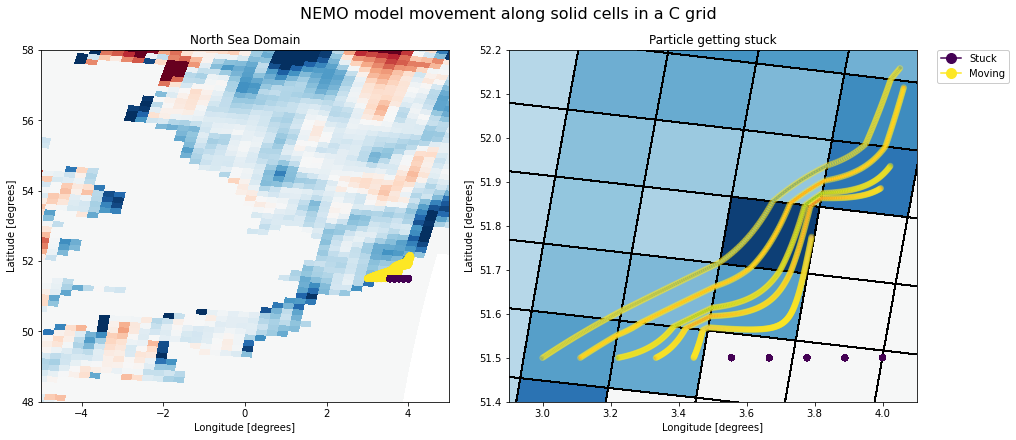

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6),constrained_layout=True)
fig.suptitle('NEMO model movement along solid cells in a C grid', fontsize=16)

ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('North Sea Domain')
ax1.set_xlim(-5, 5)
ax1.set_ylim(48, 58)

ax1.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1)
ax1.plot(data_NEMO['lon'].T, data_NEMO['lat'].T,linewidth=3,zorder=1)
ax1.scatter(data_NEMO['lon'], data_NEMO['lat'], c=stuck, cmap='viridis_r', zorder=2)

ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(2.9, 4.1)
ax2.set_ylim(51.4, 52.2)

ax2.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1,edgecolors='k',linewidth=1)
ax2.plot(data_NEMO['lon'].T, data_NEMO['lat'].T,linewidth=3,zorder=1)
ax2.scatter(data_NEMO['lon'], data_NEMO['lat'], c= stuck, s=30, cmap='viridis_r', alpha=0.3, zorder=2)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10)]
ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

As we can see the particles move along the boundary since the cross-boundary component goes to zero but the along-boundary component is equal to the value away from the coast.

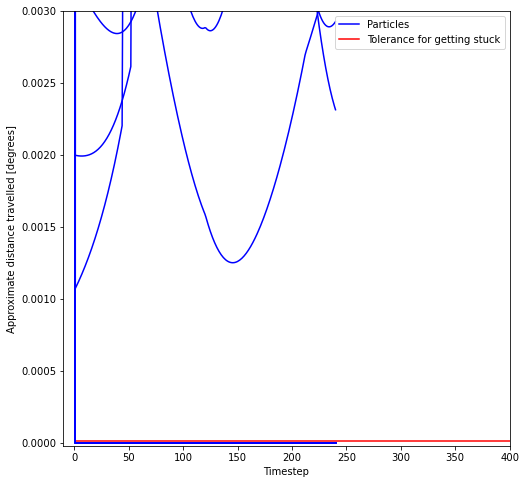

In [29]:
fig = plt.figure(figsize=(8,8))
ax=plt.axes()

ax.plot(distance.T, color='b')
ax.hlines(1e-5,0,400, color='r')
ax.set_ylabel('Approximate distance travelled [degrees]')
ax.set_xlabel('Timestep')
ax.set_ylim(-0.00002,0.003)
ax.set_xlim(-10, 400)
custom_lines = [Line2D([0], [0], c = 'b'),
                Line2D([0], [0], c = 'r')]
ax.legend(custom_lines, ['Particles', 'Tolerance for getting stuck'], loc='upper right')
plt.show()

The free-slip or partial-slip boundary results in a tangential flow along the boundary.